# Анализ рынка заведений общественного питания Москвы

**Задача:**

Задача проекта - исследовать заведений рынок общественного питания Москвы. Заказчик планирует открыть в Москве необычное кафе - вместо официантов гостей будут обслуживать роботы. Однако инвесторы неуверены, сможет ли такой проект снискать популярность. Необходимо провести общее исследование рынка заведений, изучить его особенности и предоставить рекомендации по расположению и другим характеристикам для нового кафе.

## 1 Вывод данных и предобработка

В нашем распоряжении таблица, содержащая данные о заведениях общественного питания Москвы. Таблица содержит следующие столбцы:
* **id** — идентификатор объекта;
* **object_name** — название объекта общественного питания;
* **chain** — сетевой ресторан;
* **object_type** — тип объекта общественного питания;
* **address** — адрес;
* **number** — количество посадочных мест.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import re
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
# pip install -U seaborn

In [3]:
# импорт данных
rest_data = pd.read_csv('/datasets/rest_data.csv')

Напишем функцию, которая выводит первые пять строк таблицы, информацию о таблице, количество пропустков в столбцах и количество дубликатов:

In [4]:
def info(data):
    display(data.head())
    print('Информация о таблице')
    display(data.info())
    print('Количество пропусков')
    display(data.isnull().sum())
    print('Количество дубликатов')
    display(data.duplicated().sum())

In [5]:
info(rest_data)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

Количество пропусков


id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Количество дубликатов


0

In [6]:
# приведем названия заведений к нижнему регистру, чтобы избавиться от части неявных дубликатов
rest_data['object_name'] = rest_data['object_name'].str.lower()

В таблице не обнаружено не пропусков ни явных дубликатов. Данные готовы к работе.

## 2 Анализ данных

### 2.1 Исследование соотношения видов объектов общественного питания по количеству

Посчитаем количество заведений каждого типа в городе и их долю среди всех заведений. Построим график.

,count,ratio
object_type,,
кафе,6099,0.40
столовая,2587,0.17
ресторан,2285,0.15
предприятие быстрого обслуживания,1923,0.13
бар,856,0.06
буфет,585,0.04
кафетерий,398,0.03
закусочная,360,0.02
магазин (отдел кулинарии),273,0.02


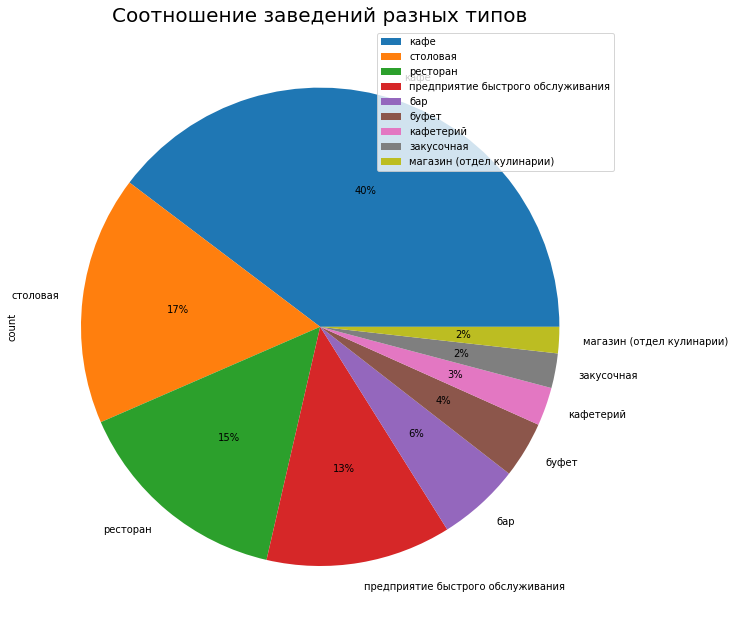

In [7]:
# группировка по типу заведения, подсчет количества заведений каждого типа
object_count = rest_data.groupby(['object_type']).agg(
    {'id':'count'}).rename(
    columns={'id':'count'}).sort_values(
    by='count',ascending=False)

# подсчет доли завелений каждого типа среди всех заведений
object_count['ratio'] = round(object_count['count'] / object_count['count'].sum(),2)

display(object_count)
object_count.plot(y='count', kind = 'pie',figsize=(11,11),autopct='%1.f%%')
plt.title("Соотношение заведений разных типов", fontsize = 20)
plt.show()

Видно, что больше всего в городе кафе (40%), на втором месте столовые (17%), на третьем рестораны (15%).

### 2.2 Исследование соотношения сетевых и несетевых заведений по количеству

Посчитаем количество сетевых и несетевых заведений в городе и их долю от общего числа заведений. Построим график.

,count,procent
chain,,
да,2968,0.19
нет,12398,0.81


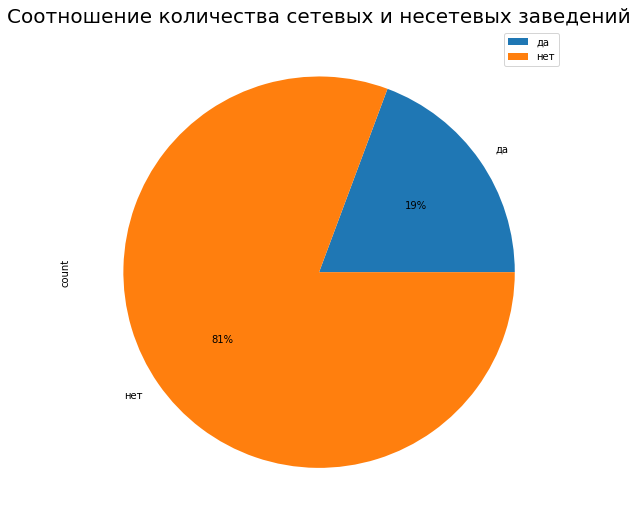

In [8]:
# группирока по chain, подсчёт количества заведений
chain_count = rest_data.groupby('chain').agg({'id':'count'}).rename(columns={'id':'count'})

# считаем долю от общего числа заведений
chain_count['procent'] = round(chain_count['count'] / chain_count['count'].sum(),2)
display(chain_count)
chain_count.plot(y='count', kind = 'pie',figsize=(9,9),autopct='%1.f%%')
plt.title("Соотношение количества сетевых и несетевых заведений", fontsize = 20)
plt.show()

Видим, что несетевых заведений значительно больше - 81%, и только 19% сетевых.

### 2.3 Для каких видов объектов общественного питания характерно сетевое распространение?

Построим график с количествами сетевых и несетевых заведений для каждого вида объекта.

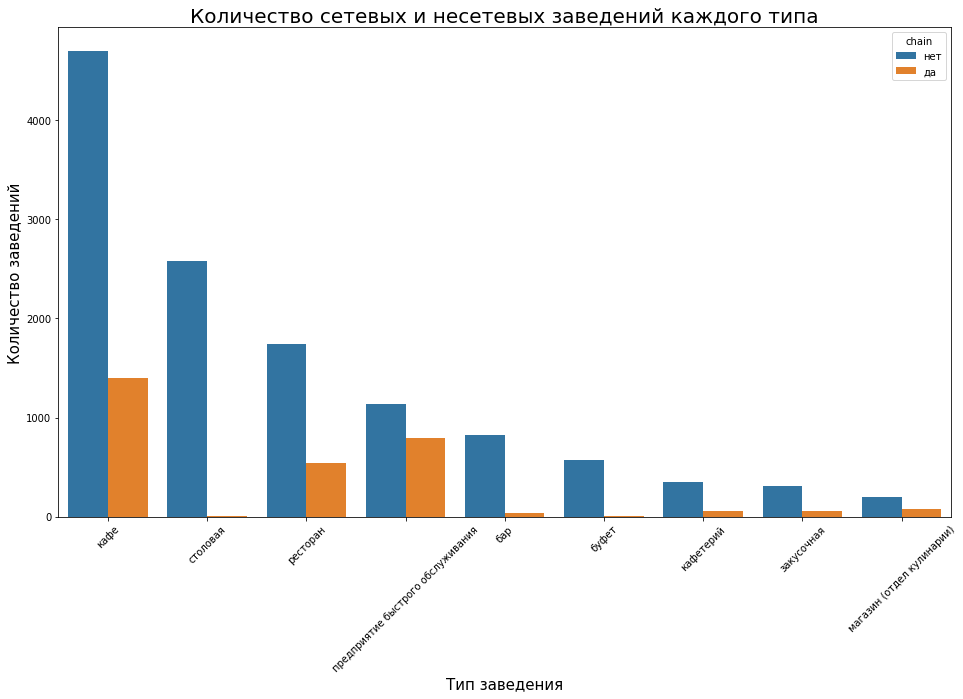

In [9]:
plt.figure(figsize=(16,9))
sns.barplot(data=rest_data.groupby(
    ['object_type','chain'],as_index=False).agg(
    {'id':'count'}).sort_values(by='id',ascending=False),
            x='object_type',y='id',hue='chain')
plt.xticks(rotation=45)
plt.title("Количество сетевых и несетевых заведений каждого типа", fontsize = 20)
plt.xlabel("Тип заведения", fontsize = 15)
plt.ylabel("Количество заведений", fontsize = 15)
plt.show()

По графику видно, что самая большая доля сетевых заведений среди преприятий быстрого обслуживания. Посмотрим детальнее, построим сводую таблицу и узнаем долю сетевых заведений для каждого типа.

In [10]:
# строим сводную таблицу
chain_object = rest_data.pivot_table(index='object_type',columns='chain',values='id',aggfunc='count')
# считаем долю сетевых заведений
chain_object['chain_procent'] = round(chain_object['да'] / (chain_object['нет']+chain_object['да']),2)

chain_object = chain_object.sort_values(by='chain_procent',ascending=False)
chain_object

chain,да,нет,chain_procent
object_type,,,
предприятие быстрого обслуживания,791,1132,0.41
магазин (отдел кулинарии),78,195,0.29
ресторан,544,1741,0.24
кафе,1396,4703,0.23
закусочная,56,304,0.16
кафетерий,52,346,0.13
бар,37,819,0.04
буфет,11,574,0.02
столовая,3,2584,0.00


Построим график.

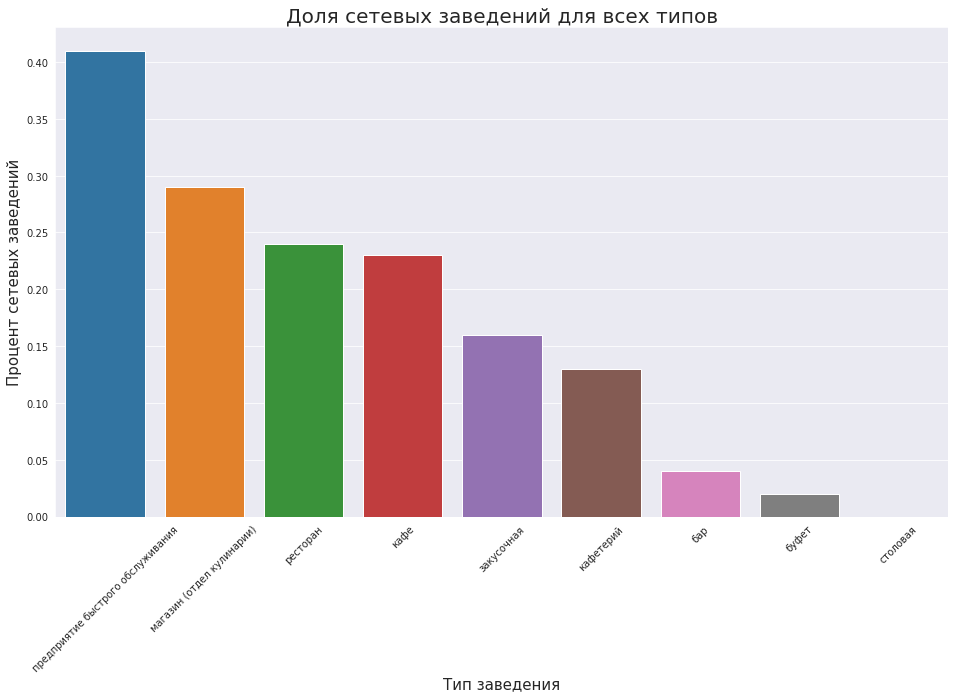

In [11]:
plt.figure(figsize=(16,9))

sns.set_style("darkgrid")
sns.barplot(data=chain_object,x=chain_object.index,y='chain_procent')
plt.xticks(rotation=45)
plt.title("Доля сетевых заведений для всех типов", fontsize = 20)
plt.xlabel("Тип заведения", fontsize = 15)
plt.ylabel("Процент сетевых заведений", fontsize = 15)
plt.show()

Из графика видно, что сетевое распространение наиболее характерно для предприятий быстрого обслуживния, 40% заведений данного типа - сетевые. Также довольно много сетей среди магазинов - 30%, среди ресторанов и кафе уже меньше - 23-24%, а среди остальных типов сетей совсем мало, ну а столовые вообще все в одном экземпляре.

### 2.4 Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [12]:
# увеличим количество символов в строках, чтобы все названия поместились
pd.options.display.max_rows = 200

Сначала попробуем привести названия заведений к единообразию и избавиться от неявных дубликатов. Есть следующие проблемы:

* тип заведения в столбце с названиями (напр. "кальянная мята launge")
* названия заведений на русском и английском языках ('старбакс' и 'starbucks')
* кавычки

In [13]:
# удаляем стоп-слова
stop = ['кафе','пиццерия','ресторан','бар','кофейня','лаундж-бар','предприятие', 'быстрого', 'обслуживания','питания']
rest_data['object_name'] = rest_data['object_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [14]:
# подчищаем кавычки
rest_data['object_name'] = rest_data['object_name'].replace('\«|\»','',regex=True)
# объединяем группы с одинаковыми названиями на русском и английском
rest_data['object_name'] = rest_data['object_name'].replace('старбакс','starbucks',regex=True)
rest_data['object_name'] = rest_data['object_name'].replace('сабвей','subway',regex=True)

In [15]:
# проверка
rest_data['object_name'].head()

0            сметана
1             родник
2           академия
3         пиццетория
4    вишневая метель
Name: object_name, dtype: object

Более-менее прибрались. Конечно осталось ещё много дубликатов, но по крайней мере теперь получится сгруппировать самые крупные сети. Сделаем срез по сетевым заведениям, сгруппруем данные по названиям заведений, посчитаем количество заведений в сети и медианные количества посадочных мест (используем медиану, т.к она более устойчива к выбросам.

In [16]:
# группировка по сетям, подсчет количества заведений и медианное кол-во мест
chain_number = rest_data.query('chain == "да"').groupby('object_name').agg(
    {'id':'count','number':'median'}).rename(
    columns={'id':'count'}).sort_values(by=['count'],ascending=False)

display(chain_number.head(10))

,count,number
object_name,,
шоколадница,183,50.0
kfc,173,45.0
макдоналдс,171,76.0
бургер кинг,149,45.0
теремок,107,24.0
домино'с пицца,98,16.0
крошка картошка,95,15.0
милти,75,0.0
суши wok,75,6.0


Попробуем разделить наши сети по категориям в зависимости от количества посадочных мест. Для этого напишем функцию, которая разделит заведения в сети на маленькие, средние, большие и очень большие. Нет никаких правил, какое заведения считается маленьким, поэтому будем считать маленькими заведения, в которых меньше 10 мест, средними - от 10 до 50 мест, большими - от 50 до 100 мест, очень большими - больше 100 мест.

In [17]:
# функция разбивки по категориям
def category(number):
    if number <= 10:
        return 'маленькое'
    if 10 < number <= 50:
        return 'среднее'
    if 50 < number <= 100:
        return 'большое'
    else:
        return 'очень большое'

In [18]:
# применение функции
chain_number['category'] = chain_number['number'].apply(category)
chain_number

,count,number,category
object_name,,,
шоколадница,183,50.0,среднее
kfc,173,45.0,среднее
макдоналдс,171,76.0,большое
бургер кинг,149,45.0,среднее
теремок,107,24.0,среднее
...,...,...,...
метро к&к,1,80.0,большое
милано пицца,1,20.0,среднее
vanwok ванвок,1,20.0,среднее


Теперь сгруппируем данные по категориям и посмотрим, каких заведений больше.

In [19]:
# группирова по категориям
chain_number.groupby('category').agg({'count':'count'}).sort_values(by='count',ascending=False)

,count
category,
среднее,196
большое,119
маленькое,65
очень большое,56


Получается, для московских сетей наиболее характеры заведения со средней посадкой - с количеством посадочных мест от 10 до 50.

Построим точечный график:

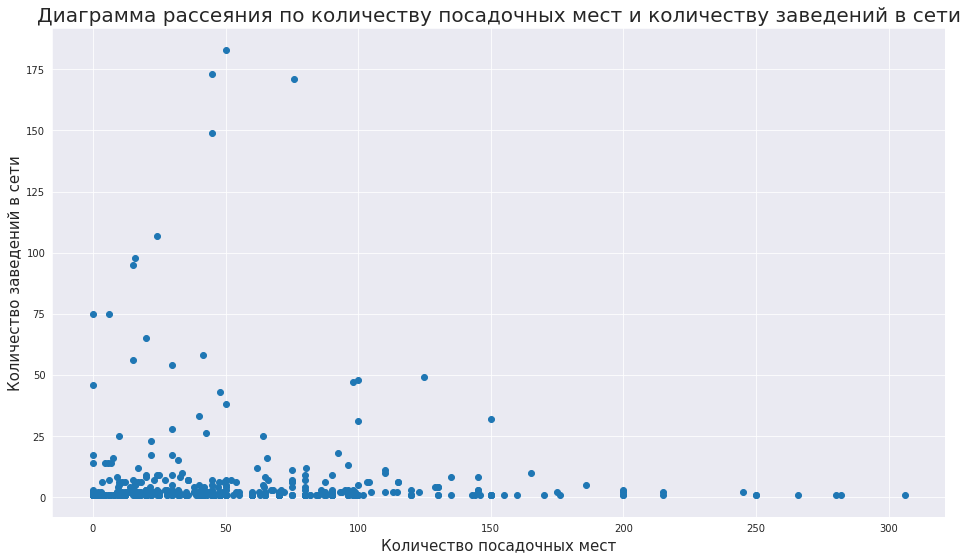

In [20]:
# строим точечный график
plt.figure(figsize=(16,9))
plt.scatter(chain_number['number'],chain_number['count'])

plt.title("Диаграмма рассеяния по количеству посадочных мест и количеству заведений в сети", fontsize = 20)
plt.xlabel("Количество посадочных мест", fontsize = 15)
plt.ylabel("Количество заведений в сети", fontsize = 15)
plt.show()

По графику можно сказать, что подавляющее большинство сетей включают в себя заведения с количеством посадочных мест от нуля (фудкорты) до 100. Есть сети-гиганты типа Макдональдса, Кфс, Старбакс и др, для которых характерно огромное количество заведений с небольшим количеством мест (50-60), а есть сети, в которых всего 1-2 ресторана, но зато количество посадочных мест больше 200.

Нельзя сказать однозначно, что больше характерно для московских сетей - ведь и рекордсмены по количеству посадочных мест и по количеству заведений сети присутствуют в примерно равном небольшом количестве. Наиболее харатерными можно назвать **некрупные сети с количеством ресторанов до 10-ти и с количеством посадочных мест до 100**. Также можно отметить, что нет ни одной сети, в которой было бы одновременно и много заведений и большое количество посадочных мест в них.

### 2.5 У заведений какого типа самое большое среднее количество посадочных мест?

Посчитаем среднее количество посадочных мест для всех типов заведений. Построим график.

In [21]:
mean_number = rest_data.groupby('object_type').agg({'number':'mean'}).sort_values(by='number',ascending=False)
mean_number['number'] = mean_number['number'].astype('int')
mean_number

,number
object_type,
столовая,130
ресторан,96
буфет,51
бар,43
кафе,39
предприятие быстрого обслуживания,20
кафетерий,9
закусочная,7
магазин (отдел кулинарии),5


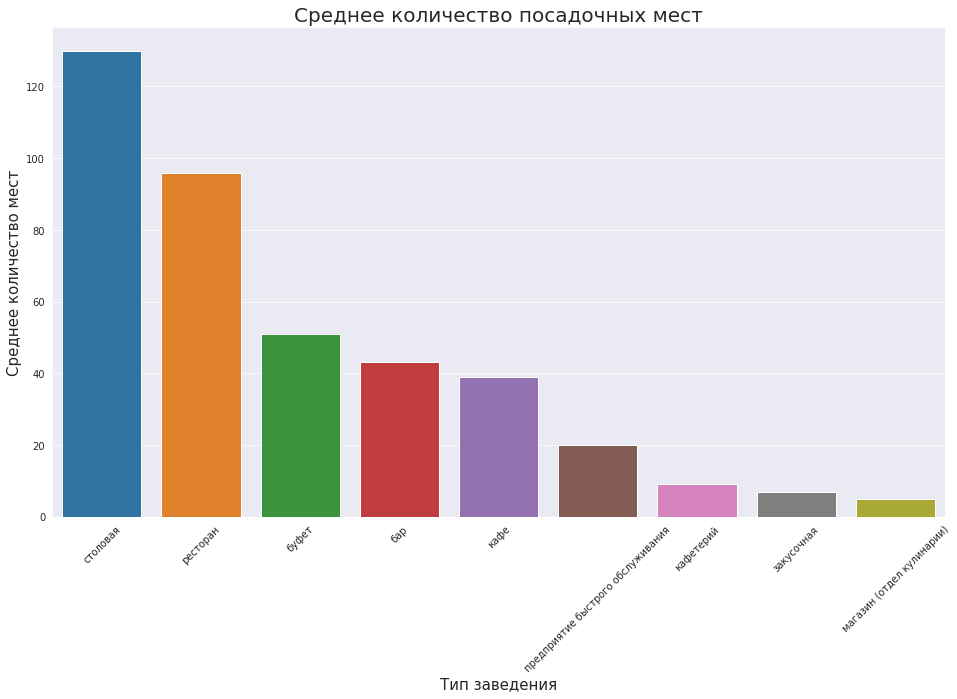

In [22]:
plt.figure(figsize=(16,9))

sns.barplot(data=mean_number,x=mean_number.index,y='number')
plt.xticks(rotation=45)
plt.title("Среднее количество посадочных мест", fontsize = 20)
plt.xlabel("Тип заведения", fontsize = 15)
plt.ylabel("Среднее количество мест", fontsize = 15)
plt.show()

В среднем больше всего посадочных мест в столовых и ресторанах, меньше всего в магазинах и закусочных.

### 2.6 Вынос улицы в отдельный столбец

Чтобы выделить информацию об улице в отдельный столбец, напишем регулярное выражение, с помощью которого отберем из адреса часть строки между запятыми, содержащую обозначение улицы (слова "улица","переулок" и т.д).

In [23]:
# функция, выделяющая улицу из адреса
def reg2(string):
    pattern = '(, (?:\d-\w|улица|бульвар|переулок|проспект|шоссе|проезд|набережная|площадь|вал|аллея|проезд|тупик) [^,]+,)|, [^,]+ (?:улица|бульвар|переулок|проспект|шоссе|проезд|набережная|площадь|вал|аллея|проезд|тупик),'
    string_new = re.search(pattern, string)
    return string_new

Полученную функцию применим к нашим адресам:

In [24]:
#увеличиваем максимальное количество символов в строках
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  

rest_data['streets'] = rest_data['address'].apply(reg2)
rest_data['streets'].head()

0    <re.Match object; span=(12, 36), match=', улица Егора Абакумова,'>
1         <re.Match object; span=(12, 31), match=', улица Талалихина,'>
2     <re.Match object; span=(12, 35), match=', Абельмановская улица,'>
3       <re.Match object; span=(12, 33), match=', Абрамцевская улица,'>
4       <re.Match object; span=(12, 33), match=', Абрамцевская улица,'>
Name: streets, dtype: object

Названия улиц сохранились в виде Match object, пока что оставим как есть, и проверим, все ли улицы удалось найти.

In [25]:
# ищем адреса, на которых функция не сработала
rest_data.query('streets.isnull()')['address'].head(10)

859                      Партизанская улица, дом 30
860                      Партизанская улица, дом 30
1405     город Москва, город Зеленоград, корпус 401
1406     город Москва, город Зеленоград, корпус 435
1407     город Москва, город Зеленоград, корпус 436
1408     город Москва, город Зеленоград, корпус 438
1409     город Москва, город Зеленоград, корпус 438
1410    город Москва, город Зеленоград, корпус 834А
1411    город Москва, город Зеленоград, корпус 1106
1412    город Москва, город Зеленоград, корпус 1449
Name: address, dtype: object

После тщательного визуального анализа адресов, на которых функция не сработала, становится понятно, что в подавляющем большинстве это адреса без улиц - с ними можно попрощаться, так как наша дальнейшая работа будет связана именно с улицами, пользы они все равно не принесут. Есть также несколько "нешаблонных" адресов, например, Партизанская улица. Таких адресов очень мало, бороться за них и дальше усложнять выражение считаю не целесообразным. В общем, удаляем все пропуски.

In [26]:
# удаление пропусков
rest_data = rest_data.dropna()
rest_data['streets'].isnull().sum()

0

Теперь, когда в столбце нет пропусков, можно привести его в порядок, преобразовать данные в сторки и убрать лишние запятые. Для этого используем ещё одну функцию:

In [27]:
# функция для "чистки" столбца с улицами
def beauty_reg(string):
    new_string = string.group()
    new_string = new_string.replace(',','').lstrip(' ')
    return new_string

In [28]:
rest_data['streets'] = rest_data['streets'].apply( beauty_reg)
rest_data.head()

,id,object_name,chain,object_type,address,number,streets
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Готово! Теперь у нас есть отдельный столбец с улицей.

### 2.7 Топ-10 улиц по количеству объектов общественного питания и их районы

Сгруппируем данные по улицам и посчитаем количество заведений, расположеных на них. Выделим Топ-10 улиц с самым большим количеством заведений. Построим график.

In [29]:
# группировка по улицам и подсчёт объектов питания на них
top10_streets = rest_data.groupby('streets',as_index=False).agg(
    {'id':'count'}).rename(
    columns={'id':'object_caunt'}).sort_values(
        by='object_caunt',ascending=False).reset_index(drop=True).head(10)

top10_streets

,streets,object_caunt
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,171
3,Пресненская набережная,167
4,Варшавское шоссе,164
5,Ленинский проспект,147
6,проспект Вернадского,132
7,Кутузовский проспект,114
8,Каширское шоссе,112
9,Кировоградская улица,110


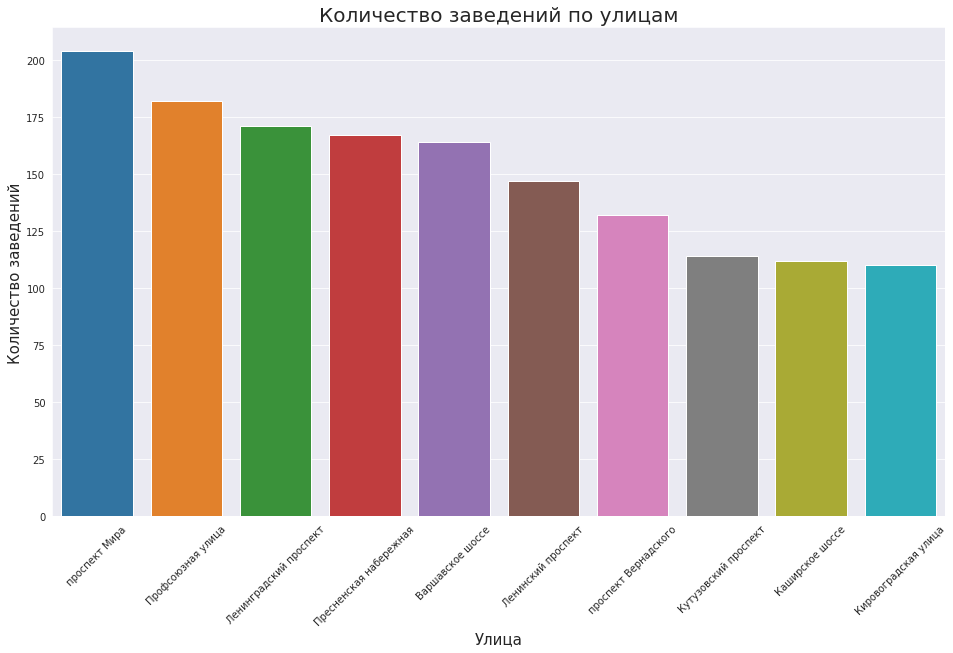

In [30]:
plt.figure(figsize=(16,9))

sns.barplot(data=top10_streets,x='streets',y='object_caunt')
plt.xticks(rotation=45)
plt.title("Количество заведений по улицам", fontsize = 20)
plt.xlabel("Улица", fontsize = 15)
plt.ylabel("Количество заведений", fontsize = 15)
plt.show()

Чтобы определить, в каких районах Москвы находятся улицы с наибольшим количеством заведений, используем csv-файл с улицами и районами Москвы, найденный в интернете. (вот здесь: https://noosphere.ru/pubs/714051)

In [31]:
# загружаем данные о районах
from io import BytesIO 
import requests 
spreadsheet_id = '1TV6f5u5-Tv6zh4pthRWu5LvbhRIhHEBsWf77Icboxhk' 
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id) 
r = requests.get(file_name) 
msk_streets = pd.read_csv(BytesIO(r.content)) 
msk_streets

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


Удалим лишние столбцы и переименуем оставшиеся.

In [32]:
msk_streets = msk_streets[['streetname','area']]
msk_streets = msk_streets.rename(columns={'streetname':'streets'})
msk_streets.head()

,streets,area
0,Выставочный переулок,Пресненский район
1,улица Гашека,Пресненский район
2,Большая Никитская улица,Пресненский район
3,Глубокий переулок,Пресненский район
4,Большой Гнездниковский переулок,Пресненский район


Проверим столбец streets на дубликаты.

In [33]:
msk_streets['streets'].duplicated().sum()

794

В столбце streets содержится много дубликатов. Это связано с тем, что многие улицы проходят через несколько районов города. Дубликаты помешают при объединении таблиц, чтобы решить проблему и не потерять данные о районах, сгруппируем данные по улицам и обернем районы, относящиеся к одной улице, в список.

In [34]:
msk_streets_group = msk_streets.groupby('streets',as_index=False).agg({'area':lambda x:list(x)})
display(msk_streets_group.head(10))

,streets,area
0,1-й Автозаводский проезд,[Даниловский район]
1,1-й Амбулаторный проезд,[Район Аэропорт]
2,1-й Архивный переулок,[Район Хамовники]
3,1-й Бабьегородский переулок,[Район Якиманка]
4,1-й Балтийский переулок,[Район Аэропорт]
5,1-й Басманный переулок,"[Басманный район, Красносельский район]"
6,1-й Белокаменный проезд,[Район Богородское]
7,1-й Богучарский переулок,[Район Южное Бутово]
8,1-й Ботанический проезд,[Район Свиблово]
9,1-й Боткинский проезд,[Район Беговой]


Объединим таблицы:

In [35]:
top10_streets_area = top10_streets.merge(msk_streets_group,on='streets',how='left')
top10_streets_area

,streets,object_caunt,area
0,проспект Мира,204,"[Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район]"
1,Профсоюзная улица,182,"[Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан]"
2,Ленинградский проспект,171,"[Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол]"
3,Пресненская набережная,167,[Пресненский район]
4,Варшавское шоссе,164,"[Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Севе..."
5,Ленинский проспект,147,"[Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан..."
6,проспект Вернадского,132,"[Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район]"
7,Кутузовский проспект,114,"[Район Дорогомилово, Район Фили-Давыдково]"
8,Каширское шоссе,112,"[Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное]"
9,Кировоградская улица,110,"[Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное]"


Готово, теперь каждой улице из Топ-10 соотвествует район или районы, в которых она находится. Закономерно получается, что улицы, на которых расположено самое большое количество заведений - это проспекты и шоссе, проходящие чуть ли ни через весь город.

### 2.8 Улицы с одним объектом общественного питания и их районы

Найдем количество улиц с одним заведением. Для этого сгруппируем данные по улицам, посчитаем количество заведений и сделаем срез по улицам с одим заведением. Возможно, на них также находятся крупные ТЦ с большим скоплением заведений.

In [36]:
one_object_streets = rest_data.groupby('streets',as_index=False).agg(
    {'id':'count'}).rename(
    columns={'id':'object_caunt'}).sort_values(
        by='object_caunt',ascending=False).query('object_caunt == 1').reset_index(drop=True)

one_object_streets

,streets,object_caunt
0,Родниковая улица,1
1,улица Медиков,1
2,3-й Лучевой просек,1
3,Нововладыкинский проезд,1
4,улица Медведева,1
...,...,...
546,улица Богданова,1
547,улица Богородский Вал,1
548,Брошевский переулок,1
549,Бродников переулок,1


Добавим в таблицу данные о районах. 

In [37]:
one_object_streets = one_object_streets.merge(msk_streets_group,on='streets',how='left')
one_object_streets

,streets,object_caunt,area
0,Родниковая улица,1,[Район Солнцево]
1,улица Медиков,1,[Район Царицыно]
2,3-й Лучевой просек,1,[Район Сокольники]
3,Нововладыкинский проезд,1,[Район Отрадное]
4,улица Медведева,1,[Район Косино-Ухтомский]
...,...,...,...
546,улица Богданова,1,[Район Солнцево]
547,улица Богородский Вал,1,"[Район Богородское, Район Преображенское]"
548,Брошевский переулок,1,[Таганский район]
549,Бродников переулок,1,[Район Якиманка]


Теперь мы знаем, в каких районах находятся все улицы с одним заведеним.

In [38]:
one_object_streets['area'] = one_object_streets['area'].astype(str)
one_object_streets.head()

,streets,object_caunt,area
0,Родниковая улица,1,['Район Солнцево']
1,улица Медиков,1,['Район Царицыно']
2,3-й Лучевой просек,1,['Район Сокольники']
3,Нововладыкинский проезд,1,['Район Отрадное']
4,улица Медведева,1,['Район Косино-Ухтомский']


Выведем Топ-10 районов, в которых больше всего улиц с одним заведением:

In [39]:
one_object_streets.groupby('area').agg({'object_caunt':'count'}).sort_values(by='object_caunt',ascending=False).head(10)

,object_caunt
area,
nan,32
['Таганский район'],25
['Басманный район'],23
['Район Хамовники'],22
['Тверской район'],19
['Район Сокольники'],15
['Пресненский район'],15
['Мещанский район'],14
['Район Марьина роща'],14


Судя по карте, большинство из этих районов находятся в центре Москвы. Видимо, там много мелких коротких улочек, поэтому частно бывает, что заведение только одно.

### 2.9 Распределение количества посадочных мест для улиц самых популярных улиц

Создадим список улиц из Топ-10 с самым больим количеством заведений.

In [40]:
top10_list = list(top10_streets['streets'])
top10_list

['проспект Мира',
 'Профсоюзная улица',
 'Ленинградский проспект',
 'Пресненская набережная',
 'Варшавское шоссе',
 'Ленинский проспект',
 'проспект Вернадского',
 'Кутузовский проспект',
 'Каширское шоссе',
 'Кировоградская улица']

Выберем улицы из списка и сгруппируем данные по улицам, посчитаем медиану посадочных мест.

In [41]:
top10_streets_number = rest_data.query('streets in @top10_list').groupby(['streets']).agg(
    {'number':'median'}).sort_values(by='number',ascending=False)
top10_streets_number

,number
streets,
проспект Мира,46.5
Ленинский проспект,45.0
Кутузовский проспект,40.0
Ленинградский проспект,40.0
проспект Вернадского,40.0
Варшавское шоссе,30.0
Кировоградская улица,30.0
Пресненская набережная,30.0
Каширское шоссе,25.0


Построим график:

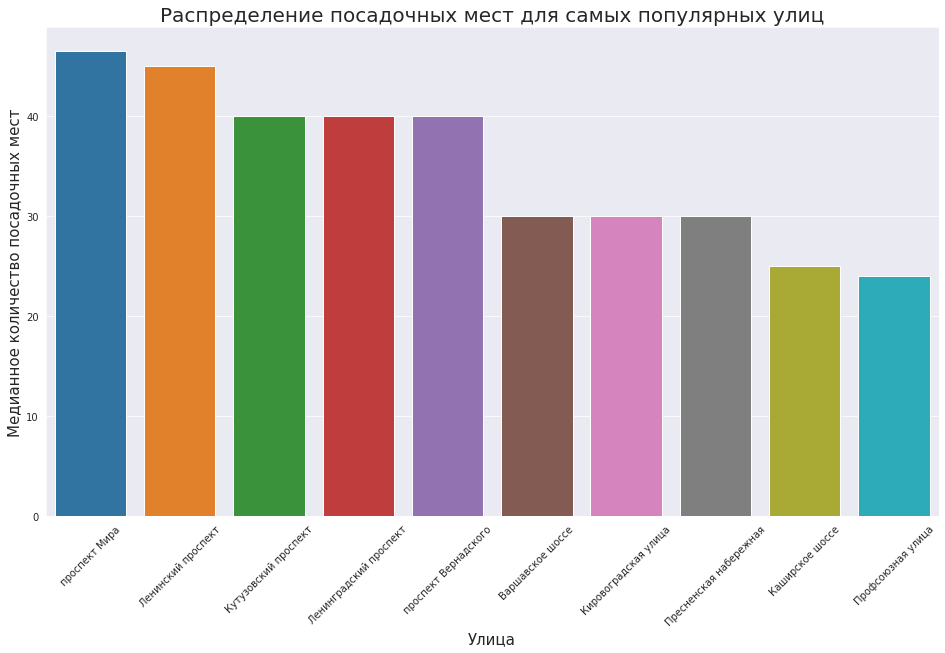

In [42]:
plt.figure(figsize=(16,9))

sns.barplot(data=top10_streets_number,x=top10_streets_number.index,y='number')
plt.xticks(rotation=45)
plt.title("Распределение посадочных мест для самых популярных улиц", fontsize = 20)
plt.xlabel("Улица", fontsize = 15)
plt.ylabel("Медианное количество посадочных мест", fontsize = 15)
plt.show()

Видно, что на проспекте Мира и Ленинском проспекте расположены более крупные заведения с 40-45 посадочными местами, самые маленькие - на Каширском шоссе и Профсоюзной улице. Вероятно, это связано с архитектурными особенностями застройки этих улиц.

Посмотрим, заведений какого типа больше всего на выбранных улицах.

In [43]:
top10_streets_type = rest_data.query('streets in @top10_list').groupby(['streets'])['object_type'].apply(lambda x:x.mode())
top10_streets_type

streets                  
Варшавское шоссе        0                                 кафе
Каширское шоссе         0    предприятие быстрого обслуживания
Кировоградская улица    0    предприятие быстрого обслуживания
Кутузовский проспект    0                             ресторан
Ленинградский проспект  0                                 кафе
Ленинский проспект      0                                 кафе
Пресненская набережная  0                                 кафе
Профсоюзная улица       0                                 кафе
проспект Вернадского    0                                 кафе
проспект Мира           0                                 кафе
Name: object_type, dtype: object

In [44]:
top_object = top10_streets_type.unique()

На большинстве улиц преобладают кафе, на Каширское шоссе и Кировоградская улица - предприятия быстрого обслуживания, на Кутузовском проспекте - рестораны.

Посмотрим, как распределены заведения самых популярных типов (кафе, рестораны и предприятия быстрого обслуживания) на выбранных улицах.

In [45]:
rest_object = rest_data.query('streets in @top10_list and object_type in @top_object').groupby(
    ['streets','object_type'],as_index=False).agg({'id':'count'}).sort_values(by=['id','object_type'],ascending=[False,False])
rest_object.head(10)

,streets,object_type,id
27,проспект Мира,кафе,103
18,Пресненская набережная,кафе,98
21,Профсоюзная улица,кафе,90
12,Ленинградский проспект,кафе,70
0,Варшавское шоссе,кафе,66
15,Ленинский проспект,кафе,64
24,проспект Вернадского,кафе,56
11,Кутузовский проспект,ресторан,48
14,Ленинградский проспект,ресторан,48
7,Кировоградская улица,предприятие быстрого обслуживания,47


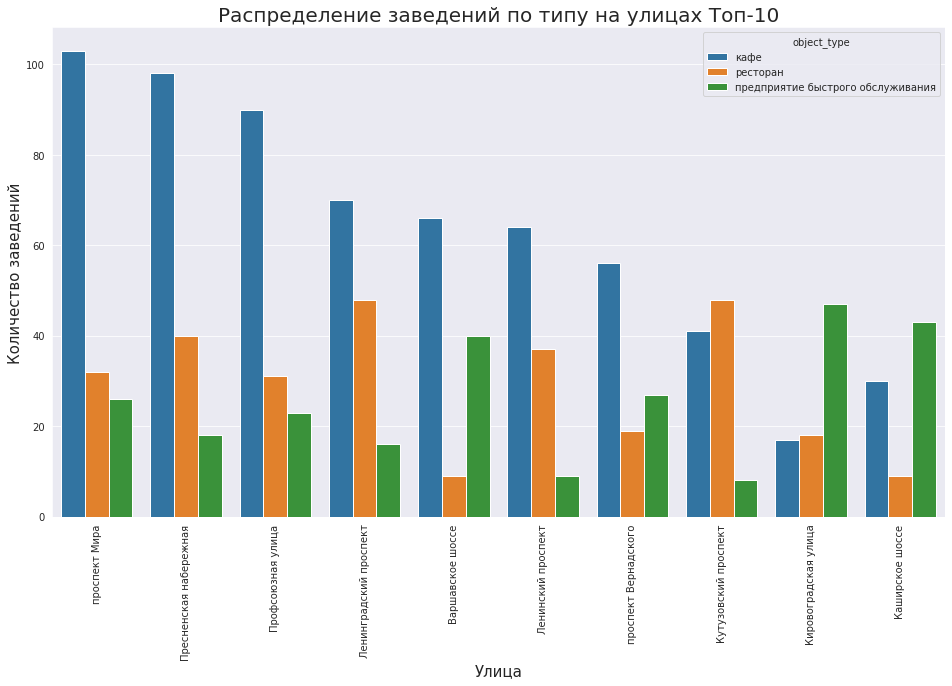

In [46]:
plt.figure(figsize=(16,9))
sns.barplot(data=rest_object,x='streets',y='id',hue='object_type')
plt.xticks(rotation=90)
plt.title("Распределение заведений по типу на улицах Топ-10", fontsize = 20)
plt.xlabel("Улица", fontsize = 15)
plt.ylabel("Количество заведений", fontsize = 15)
plt.show()

Сложно сделать однозначный вывод, где лучше открывать заведение определенного типа. С одной стороны, если открыть ресторан на улице, где их и так много, будет высокая конкуренция. С другой стороны, рисковано открывать ресторан, на улице, где преобладают предприятия быстрого обслуживания, так как, скорее всего, в этом месте основной спрос именно на них, и ресторан может оказаться невосстребован, и дело прогорит.

## Общий вывод

В ходе исследования рынка заведений общественного питания Москвы были выявлены следующие факты:

* В городе преобладают кафе, они составляют 40% всех заведений Москвы, на втором месте столовые (17%), на третьем рестораны (15%).
* 80% заведений Москвы - **несетевые**.
* Сетевое распределение характерно для **предприятий быстрого питания и магазинов с отделом кулинарии**, в меньшей степени характерно для кафе и ресторанов и совсем не характерно для буфетов и столовых.
* Для московских сетей наиболее характерно небольшое количество заведений (до 10) с небольшим и средним количеством посадочных мест (до 100), также присутствуют и крупные сети с маленькими заведениями, и маленькие сети с большими ресторанами, но и тех и других немного.
* Большое количество посадочных мест характерно для столовых и ресторанов, среднее - для кафе и баров, маленькое - для закусочных и магазинов с кулинариями.
* Улицы с самым большим количеством заведений: проспект Мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект, Каширское шоссе, Кировоградская улица.
* Районы, в которых находятся улицы с 1 заведением: Таганский район, Басманный район, Район Хамовники, Тверской район, Район Сокольники, Пресненский район, Мещанский район, Район Марьина роща, Район Замоскворечье.	
* Из самых насыщенных заведениями улиц, на проспекте Мира и Ленинском проспекте находятся заведения с большей посадкой, а на Каширском шоссе с меньшим количеством посадочных мест.
* На большинстве улиц насыщенных заведениями преобладают кафе, на Каширском шоссе и Кировоградской улице - предприятия быстрого обслуживания, на Кутузовском проспекте - рестораны.

**Рекомендации**

* По результатам исследования можно сказать, что небольшое несетевое кафе - вполне жизнеспособный вариант, таких заведений в Москве 80%. 

* Здравый смысл подсказывает, что кафе с роботами вместо официантов имеет смысл открывать в центре города, в месте большого скопления туристов, это поможет избежать того, что кафе быстро приестся публике. Нельзя однозначно рекомендовать, где лучше открывать кафе, на улицах с большим количеством заведений или на таких, где заведение только одно. Открытие кафе на улице с высокой конкурнецией рискованнее, но зато и проходимость на больше, скорее всего кафе с роботами не потеряется и сможет привлечь внимание. 

* Оптимальное количество посадочных мест для кафе - от 30 до 45, для ресторана - от 90 до 120.
* При выборе улицы и района стоит обратить внимание на преобладающий тип заведений на ней, не стоит открывать ресторан там, где люди предпочитают фастфуд.
* В городе преобладают сети с небольшим количеством заведений (2-3), если дела с робокафе пойдут хорошо, вполне можно попытаться также развить его в небольшую сеть.

Ссылка на презентацию:
<https://drive.google.com/file/d/16ZIfZpAhg6yUq-TqZqE07i0i-rpwwJ0P/view?usp=sharing>